In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

import os
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if 'fake' in file.lower() or 'job' in file.lower():
            print(os.path.join(root, file))

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


STEP 1: LOAD & EXPLORE DATASET

Dataset Shape: (17880, 18)

Columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-n

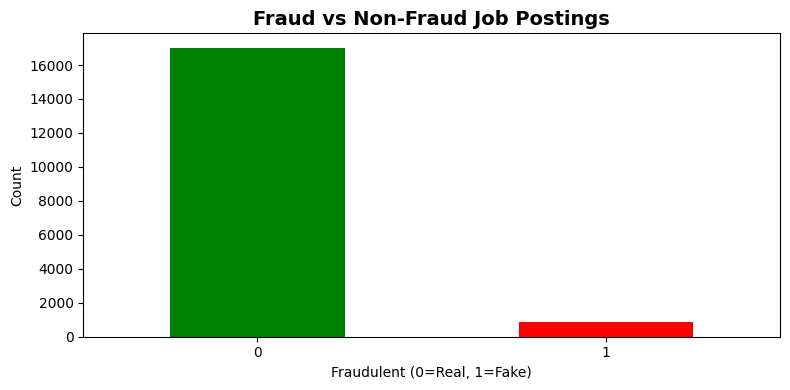

In [3]:
print("=" * 60)
print("STEP 1: LOAD & EXPLORE DATASET")
print("=" * 60)

# Load the dataset
df = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nFirst 5 rows:")
print(df.head())

print("\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# CLASS IMBALANCE CHECK
print("\nCLASS DISTRIBUTION:")
fraud_counts = df['fraudulent'].value_counts()
print(fraud_counts)
print(f"\nFraud Rate: {(fraud_counts[1] / len(df) * 100):.2f}%")

# Visualize
plt.figure(figsize=(8, 4))
fraud_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Fraud vs Non-Fraud Job Postings', fontsize=14, fontweight='bold')
plt.xlabel('Fraudulent (0=Real, 1=Fake)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [4]:
print("\n" + "=" * 60)
print("STEP 2: CLEAN & PREPROCESS TEXT")
print("=" * 60)

import re
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_html(html):
    s = MLStripper()
    try:
        s.feed(html)
        return s.get_data()
    except:
        return html

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = strip_html(text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Combine text columns
print("\nCombining text columns...")
df['full_text'] = (
    df['title'].fillna('') + ' ' +
    df['location'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['requirements'].fillna('') + ' ' +
    df['company_profile'].fillna('') + ' ' +
    df['benefits'].fillna('')
)

# Clean
print("Cleaning text...")
df['full_text'] = df['full_text'].apply(clean_text)

print("Text preprocessing complete!")
print(f"Sample cleaned text:\n{df['full_text'].iloc[0][:200]}...")



STEP 2: CLEAN & PREPROCESS TEXT

Combining text columns...
Cleaning text...
Text preprocessing complete!
Sample cleaned text:
marketing intern us, ny, new york food52, a fast-growing, james beard award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid...


In [5]:
print("\n" + "=" * 60)
print("STEP 3: BUILD ML BASELINE (TF-IDF + Logistic Regression)")
print("=" * 60)

X = df['full_text']
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)}, Test set: {len(X_test)}")

# TF-IDF Vectorizer
print("\nCreating TF-IDF vectors...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"\nLogistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))



STEP 3: BUILD ML BASELINE (TF-IDF + Logistic Regression)

Train set: 14304, Test set: 3576

Creating TF-IDF vectors...
Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.9729
F1-Score: 0.6135

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       0.99      0.45      0.61       173

    accuracy                           0.97      3576
   macro avg       0.98      0.72      0.80      3576
weighted avg       0.97      0.97      0.97      3576



In [6]:
print("\n" + "=" * 60)
print("STEP 4: DEEP LEARNING (LSTM)")
print("=" * 60)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("Tokenizing text for LSTM...")
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=200, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=200, padding='post')

print("Building LSTM model...")
lstm_model = Sequential([
    Embedding(5000, 128, input_length=200),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

print("Training LSTM (this may take 2-3 minutes)...")
lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype(int).flatten()
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_f1 = f1_score(y_test, y_pred_lstm)

print(f"\nLSTM Results:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"F1-Score: {lstm_f1:.4f}")


STEP 4: DEEP LEARNING (LSTM)


2025-11-23 16:32:50.393008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763915570.411891     431 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763915570.417202     431 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Tokenizing text for LSTM...
Building LSTM model...


I0000 00:00:1763915585.119019     431 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763915585.119684     431 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training LSTM (this may take 2-3 minutes)...


I0000 00:00:1763915589.347927     484 cuda_dnn.cc:529] Loaded cuDNN version 90300


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM Results:
Accuracy: 0.9793
F1-Score: 0.7874


In [7]:
print("\n" + "=" * 60)
print("STEP 5: FINE-TUNE TRANSFORMER (DistilBERT)")
print("=" * 60)

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\nLoading DistilBERT tokenizer...")
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts, tokenizer, max_length=128):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    return encodings

print("Tokenizing training data...")
train_encodings = tokenize_texts(X_train.reset_index(drop=True), tokenizer_bert)

print("Tokenizing test data...")
test_encodings = tokenize_texts(X_test.reset_index(drop=True), tokenizer_bert)

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train.values)
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print("\nLoading DistilBERT model...")
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

print("Fine-tuning DistilBERT (3 epochs)...")
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}/3")
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Average loss: {total_loss / len(train_loader):.4f}")

print("\nEvaluating DistilBERT on test set...")
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

bert_accuracy = accuracy_score(true_labels, predictions)
bert_f1 = f1_score(true_labels, predictions)

print(f"\nDistilBERT Results:")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"F1-Score: {bert_f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predictions))


STEP 5: FINE-TUNE TRANSFORMER (DistilBERT)
Using device: cuda

Loading DistilBERT tokenizer...
Tokenizing training data...
Tokenizing test data...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading DistilBERT model...
Fine-tuning DistilBERT (3 epochs)...

Epoch 1/3
Average loss: 0.1314

Epoch 2/3
Average loss: 0.0603

Epoch 3/3
Average loss: 0.0298

Evaluating DistilBERT on test set...

DistilBERT Results:
Accuracy: 0.9793
F1-Score: 0.7861

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.79      0.79      0.79       173

    accuracy                           0.98      3576
   macro avg       0.89      0.89      0.89      3576
weighted avg       0.98      0.98      0.98      3576




STEP 6: MODEL COMPARISON

Model Comparison Table:
                       Model  Accuracy  F1-Score
Logistic Regression (TF-IDF)  0.972875  0.613546
                        LSTM  0.979306  0.787356
                  DistilBERT  0.979306  0.786127


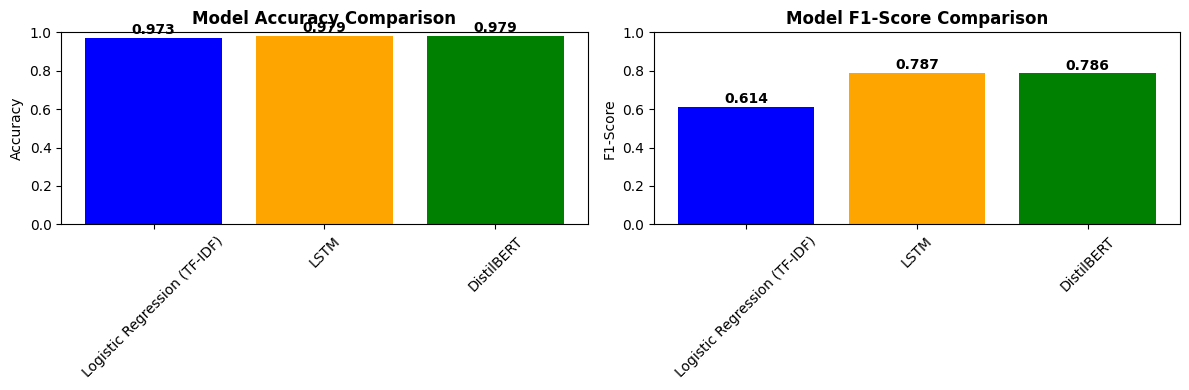

In [8]:
print("\n" + "=" * 60)
print("STEP 6: MODEL COMPARISON")
print("=" * 60)

results_df = pd.DataFrame({
    'Model': ['Logistic Regression (TF-IDF)', 'LSTM', 'DistilBERT'],
    'Accuracy': [lr_accuracy, lstm_accuracy, bert_accuracy],
    'F1-Score': [lr_f1, lstm_f1, bert_f1]
})

print("\nModel Comparison Table:")
print(results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'orange', 'green'])
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(results_df['Model'], results_df['F1-Score'], color=['blue', 'orange', 'green'])
axes[1].set_title('Model F1-Score Comparison', fontweight='bold')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0, 1])
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
print("\n" + "=" * 60)
print("STEP 7: CREATING STREAMLIT APP CODE")
print("=" * 60)

streamlit_code = '''
# Save this in a file called "app.py"
# Run with: streamlit run app.py

import streamlit as st
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import re
from html.parser import HTMLParser

st.set_page_config(page_title="Fake Job Detector", layout="centered")

st.title("🔍 Fake Job Offer Detection AI")
st.write("Paste a job description to check if it's REAL or FAKE")

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_html(html):
    s = MLStripper()
    try:
        s.feed(html)
        return s.get_data()
    except:
        return html

def clean_text(text):
    text = str(text)
    text = strip_html(text)
    text = re.sub(r'http\\S+|www\\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = text.lower()
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

@st.cache_resource
def load_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model.to(device)
    return tokenizer, model, device

tokenizer, model, device = load_model()

user_input = st.text_area("Enter job description:", height=200)

if st.button("Check Job Posting", type="primary"):
    if user_input:
        cleaned = clean_text(user_input)
        encodings = tokenizer([cleaned], max_length=128, padding=True, truncation=True, return_tensors='pt')
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            pred = torch.argmax(logits, dim=1).item()
            confidence = probs[0][pred].item() * 100
        
        if pred == 1:
            st.error(f"FAKE JOB DETECTED!")
            st.metric("Confidence", f"{confidence:.1f}%")
        else:
            st.success(f"REAL JOB")
            st.metric("Confidence", f"{confidence:.1f}%")
    else:
        st.warning("Please enter a job description!")
'''

print("\nStreamlit app code (save as 'app.py'):")
print(streamlit_code)


STEP 7: CREATING STREAMLIT APP CODE

Streamlit app code (save as 'app.py'):

# Save this in a file called "app.py"
# Run with: streamlit run app.py

import streamlit as st
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import re
from html.parser import HTMLParser

st.set_page_config(page_title="Fake Job Detector", layout="centered")

st.title("🔍 Fake Job Offer Detection AI")
st.write("Paste a job description to check if it's REAL or FAKE")

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_html(html):
    s = MLStripper()
    try:
        s.feed(html)
        return s.get_data()
    except:
        return html

def clean_text(text):
    text = str(text)
    text = strip_html(text)
    text = re.sub(r'http\S+|www\S+